In [2]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [4]:
db = client["Global_Coffee_Consumption"]

In [5]:
collection_names = db.list_collection_names()

In [6]:
print(collection_names)

['Coffee_exports', 'Coffee_production', 'Coffee_DomesticConsumption', 'Coffee_imports', 'Coffee_ImportersConsumption']


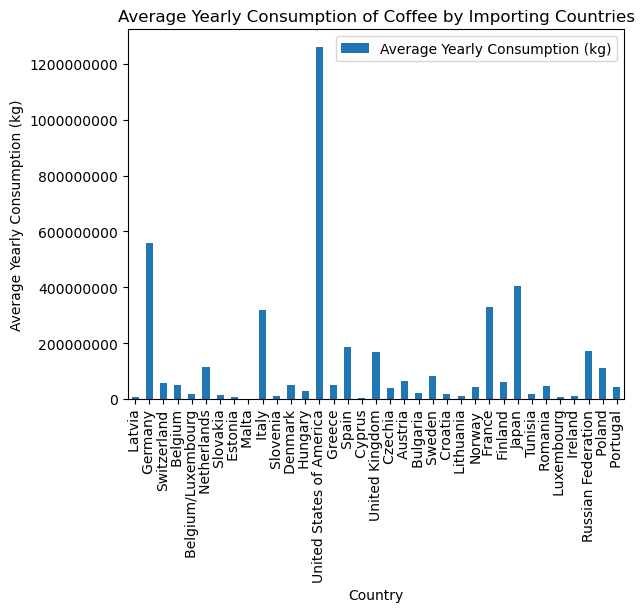

In [7]:
import_consumption = db['Coffee_ImportersConsumption'] 

#Query for finding country names
importers_data_query = import_consumption.aggregate([
    {"$group": 
     {"_id":{
        "Country": "$Country"}, 
                "count": {'$sum': 1}    
    }}
])

#Query for calculating the average consumption per year
importers_avg_query =      {
        "$group": {
            "_id":  "$Country",
            "avgConsumptionTotal": {"$avg": {"$divide": ["$Total_import_consumption", 30]}}
        }
}

pipeline = [importers_avg_query]

results = list(import_consumption.aggregate(pipeline))

importers_data = []

#Add dictionaries to list
for result in results:
    importers_data.append(result)

#Create dataframe
importers_df = pd.DataFrame(importers_data)
importers_df = importers_df.rename(columns={"_id": "Country",
                                           "avgConsumptionTotal": "Average Yearly Consumption (kg)"})
#Plot bar chart
importers_df.plot(kind="bar",
                 x="Country",
                 y="Average Yearly Consumption (kg)",
                 title="Average Yearly Consumption of Coffee by Importing Countries")
plt.xlabel("Country")
plt.ylabel("Average Yearly Consumption (kg)")

#Format the y-axis ticks in full decimal form
ax = plt.gca()
ax.yaxis.set_major_formatter('{:.0f}'.format)

plt.show()

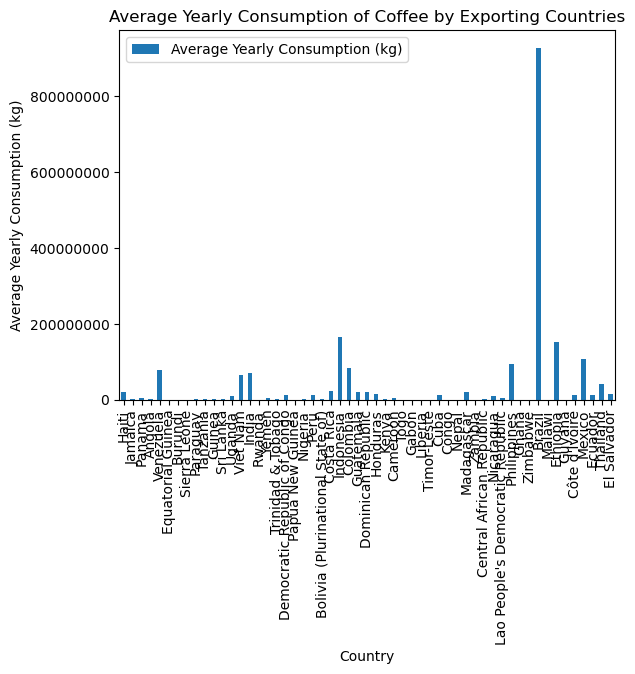

In [8]:
export_consumption = db['Coffee_DomesticConsumption'] 

#Query for finding country names
exporters_data_query = export_consumption.aggregate([
    {"$group": 
     {"_id":{
        "Country": "$Country"}, 
                "count": {'$sum': 1}    
    }}
])

#Query for calculating the average consumption per year
exporters_avg_query =      {
        "$group": {
            "_id":  "$Country",
            "avgConsumptionTotal": {"$avg": {"$divide": ["$Total_domestic_consumption", 30]}}
        }
}

pipeline = [exporters_avg_query]

results = list(export_consumption.aggregate(pipeline))

exporters_data = []

#Add dictionaries to list
for result in results:
    exporters_data.append(result)

#Create dataframe
exporters_df = pd.DataFrame(exporters_data)
exporters_df = exporters_df.rename(columns={"_id": "Country",
                                           "avgConsumptionTotal": "Average Yearly Consumption (kg)"})
#Plot bar chart
exporters_df.plot(kind="bar",
                 x="Country",
                 y="Average Yearly Consumption (kg)",
                 title="Average Yearly Consumption of Coffee by Exporting Countries")
plt.xlabel("Country")
plt.ylabel("Average Yearly Consumption (kg)")

#Format the y-axis ticks in full decimal form
ax = plt.gca()
ax.yaxis.set_major_formatter('{:.0f}'.format)

plt.show()

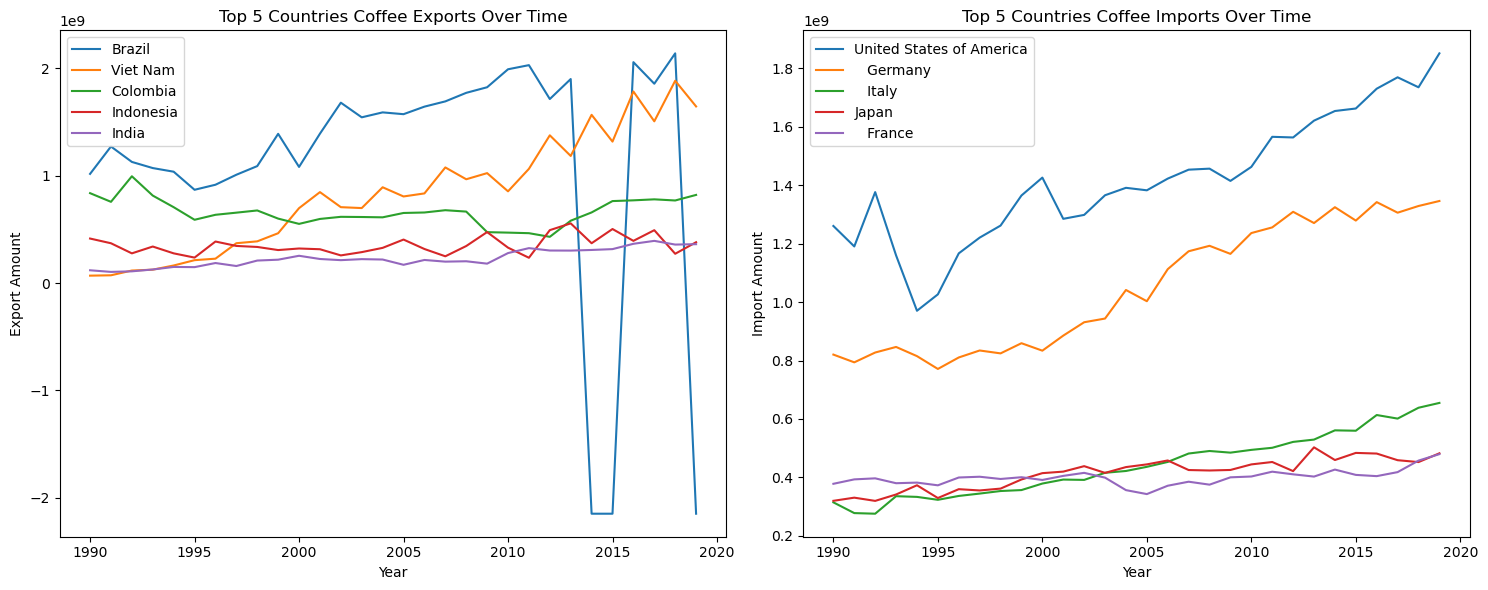

In [15]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Global_Coffee_Consumption"]

# Select the collections for exports and imports
exports_collection = db['Coffee_exports']
imports_collection = db['Coffee_imports']

# Aggregate query to calculate the total exports and imports for each country
exports_total_pipeline = [
    {"$group": {"_id": "$Country", "total_export": {"$sum": "$Total_export"}}},
    {"$sort": {"total_export": -1}},
    {"$limit": 5}
]
exports_total = list(exports_collection.aggregate(exports_total_pipeline))

imports_total_pipeline = [
    {"$group": {"_id": "$Country", "total_import": {"$sum": "$Total_import"}}},
    {"$sort": {"total_import": -1}},
    {"$limit": 5}
]
imports_total = list(imports_collection.aggregate(imports_total_pipeline))

# Get the names of the top 5 exporting and importing countries
top_export_countries = [doc['_id'] for doc in exports_total]
top_import_countries = [doc['_id'] for doc in imports_total]

# Query the annual export and import data for these top countries
exports_query = {"Country": {"$in": top_export_countries}}
imports_query = {"Country": {"$in": top_import_countries}}

exports_data = list(exports_collection.find(exports_query))
imports_data = list(imports_collection.find(imports_query))

# Transform data to a format suitable for plotting
exports_df = pd.DataFrame(exports_data).melt(id_vars=['Country'], var_name='Year', value_name='ExportAmount')
imports_df = pd.DataFrame(imports_data).melt(id_vars=['Country'], var_name='Year', value_name='ImportAmount')

# Filter data to keep only rows with year and numeric values
exports_df = exports_df[exports_df['Year'].apply(lambda x: x.isdigit())]
imports_df = imports_df[imports_df['Year'].apply(lambda x: x.isdigit())]

# Convert year to integer
exports_df['Year'] = exports_df['Year'].astype(int)
imports_df['Year'] = imports_df['Year'].astype(int)

# Plot the line charts
plt.figure(figsize=(15, 6))

# Plot exports chart
plt.subplot(1, 2, 1)
for country in top_export_countries:
    country_data = exports_df[exports_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['ExportAmount'], label=country)
plt.title('Top 5 Countries Coffee Exports Over Time')
plt.ylabel('Export Amount')
plt.xlabel('Year')
plt.legend()

# Plot imports chart
plt.subplot(1, 2, 2)
for country in top_import_countries:
    country_data = imports_df[imports_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['ImportAmount'], label=country)
plt.title('Top 5 Countries Coffee Imports Over Time')
plt.ylabel('Import Amount')
plt.xlabel('Year')
plt.legend()

plt.tight_layout()
plt.show()

